In [1]:
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
#costume classes
from model import SentimentRNN
from model_utilities import train, test, predict
from preprocessing import clean_reviews, creat_vocab, tokenize_data, pad_features, train_test_split, google_clean_reviews, clean_reviews_and_creat_vocab

In [2]:
#loading the data
# with open('yelp_academic_dataset_review.json', encoding='utf-8') as f:
#     df_review = pd.DataFrame(json.loads(line) for line in f)
df_review = pd.read_json('REVIEWS_DATA_SET_26K_EN.json')
df_review.head(2)

text  rating
0  Stopped off here as we were looking for somewh...       3
1  What a great restaurant. We went to go see the...       5

In [3]:
df_review.shape

(26633, 2)

<AxesSubplot:ylabel='Frequency'>

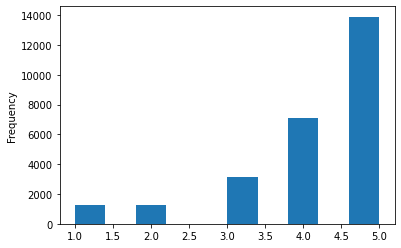

In [4]:
#plotting the rating distrubution
figure = plt.figure()

axes = figure.add_subplot(1, 1, 1)
axes.set_ylabel('Frequancy')

# df_review['stars'].plot.hist()
df_review['rating'].plot.hist()

In [5]:
#converting rating to 1/0 which is positive/negative into a new cloumn called stars
df_review['stars'] = df_review['rating'].apply(lambda x:1 if x >= 3 else 0 if x <= 2 else None)
df_review.dropna(axis=0, inplace=True)
df_review.head(5)

text  rating  stars
0  Stopped off here as we were looking for somewh...       3      1
1  What a great restaurant. We went to go see the...       5      1
2  Boy, am I glad I got to try Da Marino before t...       5      1
3  We found this gem during our mini trip to expe...       5      1
4  Donna the bartender is amazing. She is a hard ...       5      1

<BarContainer object of 2 artists>

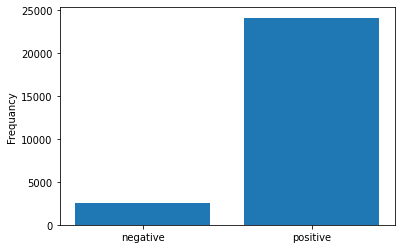

In [6]:
#plotting the pos/neg distrubution
plt.figure()

plt.ylabel('Frequancy')
plt.xticks([1, 0],['positive','negative'])

plt.bar([1, 0], df_review['stars'].value_counts())

In [7]:
from collections import Counter
from preprocessing import tokenize_data
reviews_strings = list(df_review['text'])
labels = list(df_review['stars'])
reviews_arrays, labels = tokenize_data(reviews_strings, labels, Counter(), lebals_encoded=True)
reviews_strings = None
labels = None

In [8]:
df_review['lengths'] = [len(reviews) for reviews in reviews_arrays]
reviews_arrays = None
df_review

text  rating  stars  \
0      Stopped off here as we were looking for somewh...       3      1   
1      What a great restaurant. We went to go see the...       5      1   
2      Boy, am I glad I got to try Da Marino before t...       5      1   
3      We found this gem during our mini trip to expe...       5      1   
4      Donna the bartender is amazing. She is a hard ...       5      1   
...                                                  ...     ...    ...   
26628  They have really a good burger using a good qu...       3      1   
26629  High price .. bad food tast and quality ..heav...       1      0   
26630  This was a nice sit down restaurant with food ...       2      0   
26631  I went for a dinner Sunday, reservation at 7:0...       1      0   
26632  Notably the worst experience in a fine dining ...       1      0   

       lengths  
0          109  
1           54  
2          205  
3          146  
4           32  
...        ...  
26628       19  
26629       20  
26630      213  
26631      235  
26632      154  

[26633 rows x 4 columns]

In [9]:
#sorting the values by the label so that the positive (1)
# df_review = df_review.sort_values(by=['stars', 'lengths'], ascending=[False, False])
df_review = df_review.sort_values(by='stars', ascending=False)
df_review

text  rating  stars  \
0      Stopped off here as we were looking for somewh...       3      1   
16974  The food is really good, salad bar have many o...       5      1   
17000  It is good but not unique  they don't make pas...       4      1   
16999  Food was nice and delicious  Lunch offers are ...       4      1   
16998  Liked the taste of steak and salmon, good rest...       4      1   
...                                                  ...     ...    ...   
2209   We found a place close to Book of Mormon, it i...       2      0   
5024   After doing lots of research and poring over N...       1      0   
8198   we went there with a party of 5 european trave...       2      0   
20647  Generally the atmosphere is very good. You can...       2      0   
26632  Notably the worst experience in a fine dining ...       1      0   

       lengths  
0          109  
16974       33  
17000       28  
16999       23  
16998       30  
...        ...  
2209       115  
5024       348  
8198       107  
20647       28  
26632      154  

[26633 rows x 4 columns]

In [10]:
def balance_distrubution(df, pos_percentage = 0.5):
    if df['stars'].sum(axis=0)/len(df) < pos_percentage:
        print('positive percentage is already below {}%'.format(pos_percentage*100))
        return
    
    df = df.reset_index(drop=True) 
    #taking an estimation of 1% if the total length of the dataframe
    step = int(len(df)/100)
    
    for i in range(0, df.shape[0], step):
        #dropping the amount of step of entries until the pos_percentage reaches 1% obave it
        #so that no more data than required would be deleted
        if (df['stars'].sum(axis=0)/len(df)) > (pos_percentage+0.02):
            df.drop(df.index[0:step], axis=0, inplace=True)
            df = df.reset_index(drop=True)
            print(df['stars'].sum(axis=0)/len(df))
        elif (df['stars'].sum(axis=0)/len(df)) > pos_percentage:
            #taking an estimation of the remaining data and dropping them
            #taking the positive reviews from the end to get rid of very short reviews
            remaining_data = int(((df['stars'].sum(axis=0)/len(df)) - pos_percentage) * len(df))
            postive_last_index = int(len(df)/2)-remaining_data
            df.drop(df.index[postive_last_index-remaining_data:postive_last_index], axis=0, inplace=True)
            df = df.reset_index(drop=True)  
            print(df['stars'].sum(axis=0)/len(df))
            #dropping entries one by one until it reaches pos_percentage 
            for i in range(df.shape[0]):
                if (df['stars'].sum(axis=0)/len(df)) > pos_percentage:
                    df.drop(df.index[0], axis=0, inplace=True)
                    df = df.reset_index(drop=True)
                    print(df['stars'].sum(axis=0)/len(df))
                else:
                    break        
        elif (df['stars'].sum(axis=0)/len(df)) == pos_percentage:        
            return df
        
        else:
            raise Exception()

In [11]:
balance_distrubution(df_review, pos_percentage=0.95)

positive percentage is already below 95.0%


In [12]:
df_review = balance_distrubution(df_review, pos_percentage=0.5)

0.9057154776804339
0.9047546071031761
0.9037739500677375
0.9027728890453284
0.9017507805398569
0.9007069537085114
0.8996407088934641
0.8985513160579474
0.8974380131193531
0.8963000041713595
0.8951364575863668
0.8939465039887377
0.8927292340884574
0.8914836963638745
0.8902088945811067
0.8889037851365241
0.8875672742074081
0.886198214694438
0.8847954029380416
0.8833575751888518
0.8818834038105193
0.8803714931908956
0.8788203753351207
0.8772285051113635
0.8755942551168493
0.8739159101283157
0.8721916610971159
0.8704195986447746
0.8685977060098314
0.8667238513911971
0.8647957796269103
0.8628111031400033
0.860767292075049
0.8586616635397123
0.8564913698551059
0.8542533857067479
0.8519444940742065
0.8495612708018154
0.8471000676548374
0.844556993684737
0.8419278947033764
0.8392083306383804
0.8363935505100362
0.8334784647330699
0.8304576144036009
0.8273251371813573
0.8240747293185195
0.8206996033177064
0.8171924406206339
0.8135453386334658
0.809749751281855
0.8057964221545192
0.80167530913442

In [13]:
#making sure the dataframe has been modified and to see the amount of data lost
#original number of rows is 26633 
print(df_review.shape)
print(f'the number of entries lost: {26633-df_review.shape[0]}')

(4972, 4)
the number of entries lost: 21661


<BarContainer object of 2 artists>

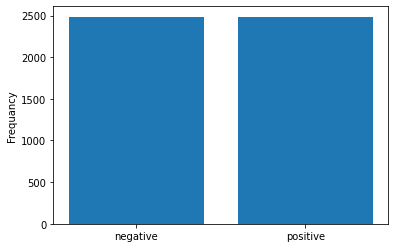

In [14]:
#plot to make sure the distrubution is the balanced
plt.figure()

plt.ylabel('Frequancy')
plt.xticks([1, 0],['positive','negative'])

plt.bar([1, 0],df_review['stars'].value_counts())

In [15]:
df_review

text  rating  stars  \
0     I was extremely impressed by Mohamed Ali Taala...       5      1   
1     Very nice food, very nice service especially A...       5      1   
2     Nisce service from ABHISHEK and delicious food...       5      1   
3     Thank you so much for good delicious food and ...       5      1   
4     Superb venue, very friendly, welcoming, and ef...       5      1   
...                                                 ...     ...    ...   
4967  We found a place close to Book of Mormon, it i...       2      0   
4968  After doing lots of research and poring over N...       1      0   
4969  we went there with a party of 5 european trave...       2      0   
4970  Generally the atmosphere is very good. You can...       2      0   
4971  Notably the worst experience in a fine dining ...       1      0   

      lengths  
0          37  
1          19  
2          30  
3          20  
4          89  
...       ...  
4967      115  
4968      348  
4969      107  
4970       28  
4971      154  

[4972 rows x 4 columns]

avarege length is 91.14581657280772


<AxesSubplot:ylabel='Frequency'>

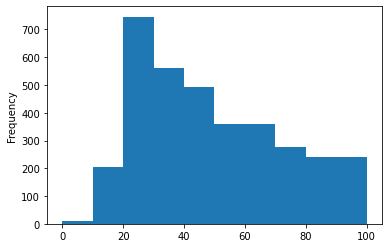

In [16]:
#plotting the length of the reviews
print('avarege length is', df_review['lengths'].mean())

df_review['lengths'].plot.hist(range=(0,100))

In [17]:
#printing the precentage of positive entries
print('distrubution (precentage of positive data): {} %'.format((df_review['stars'].sum(axis=0)/df_review.shape[0])*100))

distrubution (precentage of positive data): 50.0 %


In [18]:
df_review.drop(['lengths', 'stars'], axis=1, inplace=True)
df_review.head(5)

text  rating
0  I was extremely impressed by Mohamed Ali Taala...       5
1  Very nice food, very nice service especially A...       5
2  Nisce service from ABHISHEK and delicious food...       5
3  Thank you so much for good delicious food and ...       5
4  Superb venue, very friendly, welcoming, and ef...       5

<AxesSubplot:ylabel='Frequency'>

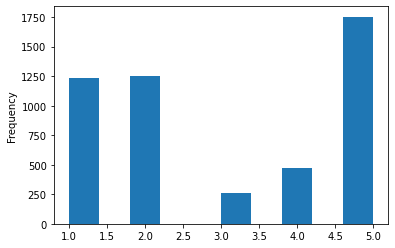

In [19]:
#plotting the rating distrubution
figure = plt.figure()

axes = figure.add_subplot(1, 1, 1)
axes.set_ylabel('Frequancy')

# df_review['stars'].plot.hist()
df_review['rating'].plot.hist()

In [24]:
#saving the data to be used later on
df_review.to_pickle('google_balanced.pkl')
df_review.to_csv('google_balanced.csv')
df_review.to_json('google_balanced.json',orient='records')

In [25]:
df1 = pd.read_pickle('google_balanced.pkl')
df1.head(10)

text  rating
0  I was extremely impressed by Mohamed Ali Taala...       5
1  Very nice food, very nice service especially A...       5
2  Nisce service from ABHISHEK and delicious food...       5
3  Thank you so much for good delicious food and ...       5
4  Superb venue, very friendly, welcoming, and ef...       5
5  When we walked in this morning, my wife made a...       5
6  The visit to Al Orjouan started from the very ...       5
7  Every thing was amazing and the food was great...       5
8  The food was excellent and service also amazin...       5
9  Nice restaurant and excellent service, the foo...       5